RMSE Estimation for Random Forest & XGBoost (before and after Reduced Overfitting) while not using train_test_split function and test and train set are fixed based on list of Typhoons.

The goal is that to compare RMSE estimated by train_test_split function (80/20 while one typhoon is considered as test each time) with the one according to train_test_split by typhoons (considering 8/39 typhoons as the test set).

In [ ]:
%load_ext jupyter_black

In [ ]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from numpy.lib.function_base import average

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

[4086 2431 1061  405   90]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


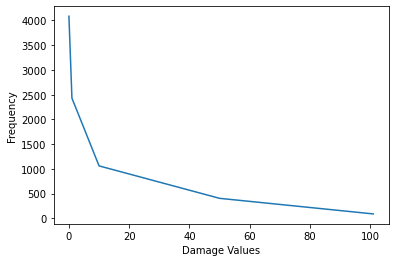

In [2]:
#Old and New set of bins
#bins2= [0, 1, 60, 101]    #Old bins
bins2 = [0, 0.00009, 1, 10, 50, 101]    #New bins
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

print(samples_per_bin2)
print(binsP2)


###The data (except target) needs to be standardize

In [3]:
#Separate target from all other data
#df_scaled = df
#df_scaled

#Separate typhoon from other features
dfs = np.split(df, [1], axis=1)
dfa = np.split(dfs[1], [36], axis=1)
#print(dfs[0], dfs[1], dfa[0], dfa[1])

#Standardaize data 
scaler = preprocessing.StandardScaler().fit(dfa[0])
X1 = scaler.transform(dfa[0])
Xnew = pd.DataFrame(X1)
display(Xnew)



,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,0.782109,...,-0.932648,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946
1,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,-0.597673,...,0.691991,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529
2,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,0.183134,...,0.009907,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326
3,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.423542,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280
4,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,2.322332,...,0.620671,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,0.332878,...,-0.207321,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720
8069,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.597539,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787
8070,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,-0.597673,...,-0.029475,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753
8071,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,-0.629761,...,0.432899,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956


In [4]:
dfa[1] = dfa[1].astype(float)

In [5]:
Xnew = pd.concat([Xnew.reset_index(drop=True), dfa[1].reset_index(drop=True)], axis=1)
Xnew

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,DAM_perc_dmg
0,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,0.782109,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,-0.597673,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,0.183134,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,2.322332,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,0.332878,...,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720,0.000000
8069,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.000000
8070,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,-0.597673,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.000000
8071,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,0.000000


In [6]:
i=0
for feature in features:
    Xnew = Xnew.rename(columns={i: feature})
    i+=1
    
Xnew = pd.concat([dfs[0].reset_index(drop=True),Xnew.reset_index(drop=True)], axis=1)
#Xnew

In [7]:
typhoons_lst = Xnew.typhoon.unique()
typhoons_lst.tolist()

['durian2006',
 'fengshen2008',
 'bopha2012',
 'fung-wong2014',
 'goni2015',
 'goni2020',
 'hagupit2014',
 'haima2016',
 'haiyan2013',
 'jangmi2014',
 'kalmaegi2014',
 'kammuri2019',
 'ketsana2009',
 'koppu2015',
 'krosa2013',
 'linfa2015',
 'lingling2014',
 'mangkhut2018',
 'mekkhala2015',
 'melor2015',
 'molave2020',
 'mujigae2015',
 'nakri2019',
 'nari2013',
 'nesat2011',
 'nock-ten2016',
 'phanfone2019',
 'rammasun2014',
 'sarika2016',
 'saudel2020',
 'tokage2016',
 'usagi2013',
 'utor2013',
 'vamco2020',
 'vongfong2020',
 'yutu2018',
 'conson2010',
 'meranti2016',
 'noul2015']

####Check the mean value of each grop of typhoon to figure out most severe typhoons.

In [8]:
#df["typhoon"].unique().tolist()
df_mean_value=pd.DataFrame(columns = ['mean_value'])
df_mean_value['mean_value'] = df.groupby('typhoon')['DAM_perc_dmg'].mean()
df_mean_value

,mean_value
typhoon,
bopha2012,1.518262
conson2010,0.217448
durian2006,5.279093
fengshen2008,1.976220
fung-wong2014,0.596001
goni2015,0.395377
goni2020,2.672981
hagupit2014,2.426598
haima2016,1.549030


In [11]:
#Choose a test set randomly among all the typhoons(no matter in terms of typhoon severity)
#lst = random.sample(typhoons_lst.tolist(),k=8)

"""Better to choose one of the lists below which are balanced in terms of typhoon severity
(half severe, half with low mean value)
"""

lst=['durian2006', 'goni2020', 'melor2015', 'rammasun2014', 'tokage2016', 'utor2013', 'vamco2020', 'haima2016']
#lst=['haiyan2013', 'yutu2018', 'meranti2016', 'kammuri2019', 'saudel2020', 'hagupit2014', 'fengshen2008', 'mekkhala2015']

lst

['durian2006',
 'goni2020',
 'melor2015',
 'rammasun2014',
 'tokage2016',
 'utor2013',
 'vamco2020',
 'haima2016']

###The next two cells, split test and train dataframe

In [12]:
df_test=pd.DataFrame(Xnew, columns = ['typhoon','HAZ_rainfall_Total',
                                    'HAZ_rainfall_max_6h',
                                    'HAZ_rainfall_max_24h',
                                    'HAZ_v_max',
                                    'HAZ_v_max_3',
                                    'HAZ_dis_track_min',
                                    'GEN_landslide_per',
                                    'GEN_stormsurge_per',
                                    'GEN_Bu_p_inSSA', 
                                    'GEN_Bu_p_LS', 
                                    'GEN_Red_per_LSbldg',
                                    'GEN_Or_per_LSblg', 
                                    'GEN_Yel_per_LSSAb', 
                                    'GEN_RED_per_SSAbldg',
                                    'GEN_OR_per_SSAbldg',
                                    'GEN_Yellow_per_LSbl',
                                    'TOP_mean_slope',
                                    'TOP_mean_elevation_m', 
                                    'TOP_ruggedness_stdev', 
                                    'TOP_mean_ruggedness',
                                    'TOP_slope_stdev', 
                                    'VUL_poverty_perc',
                                    'GEN_with_coast',
                                    'GEN_coast_length', 
                                    'VUL_Housing_Units',
                                    'VUL_StrongRoof_StrongWall', 
                                    'VUL_StrongRoof_LightWall',
                                    'VUL_StrongRoof_SalvageWall', 
                                    'VUL_LightRoof_StrongWall',
                                    'VUL_LightRoof_LightWall', 
                                    'VUL_LightRoof_SalvageWall',
                                    'VUL_SalvagedRoof_StrongWall',
                                    'VUL_SalvagedRoof_LightWall',
                                    'VUL_SalvagedRoof_SalvageWall', 
                                    'VUL_vulnerable_groups',
                                    'VUL_pantawid_pamilya_beneficiary', 
                                    'DAM_perc_dmg']) 

df_test = Xnew[Xnew['typhoon'] == lst[0]]
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[1]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[2]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[3]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[4]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[5]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[6]])
df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[7]])

df_test

/tmp/ipykernel_97280/2707052625.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[1]])
/tmp/ipykernel_97280/2707052625.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[2]])
/tmp/ipykernel_97280/2707052625.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[3]])
/tmp/ipykernel_97280/2707052625.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == lst[4]])
/tmp/ipykernel_97280/2707052625.py:44: FutureWarning: The frame.append method is

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,haima2016,-0.068308,-0.068591,0.157735,-0.598507,-0.518068,0.931965,-0.629550,-0.351584,-0.351508,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.006969
2371,haima2016,0.465922,0.632434,0.803874,-0.087565,-0.398937,-0.007550,-0.597476,-0.339573,-0.339482,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.022528
2372,haima2016,0.962137,1.297809,1.256793,0.570180,-0.022917,-0.682842,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,6.427221
2373,haima2016,-0.010412,-0.128244,0.110397,1.711985,1.570291,-1.456580,-0.052224,-0.351584,-0.351508,...,-0.375635,-0.469587,-0.852599,-0.547616,-0.321955,-0.376621,-0.480336,-1.068936,-0.919628,0.026021


In [13]:
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[0]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[1]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[2]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[3]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[4]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[5]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[6]], inplace=True)
Xnew.drop(Xnew.index[Xnew['typhoon'] == lst[7]], inplace=True)

df_train=Xnew
display(df_train)

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
355,fengshen2008,0.053623,-0.213698,-0.097624,0.172937,-0.285794,-0.558128,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
356,fengshen2008,-1.006512,-0.973211,-1.023412,-0.817648,-0.538968,1.364542,1.551459,-0.351584,-0.351508,...,-0.583838,-0.435738,-0.741231,-0.547616,-0.321955,-0.376621,-0.480336,0.151758,1.473542,0.000000
357,fengshen2008,0.857899,0.920327,0.711093,1.397208,0.983805,-1.133388,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,15.050697
358,fengshen2008,0.799866,0.218838,0.441492,0.579226,-0.015482,-0.802640,-0.394343,-0.348915,-0.348836,...,-0.532587,-0.422723,-0.683221,-0.375301,-0.175006,-0.237374,-0.403877,-1.186104,-0.353032,0.012811
359,fengshen2008,-1.007900,-0.941460,-1.008673,-0.354381,-0.475635,0.152035,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,noul2015,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,...,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720,0.000000
8069,noul2015,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.000000
8070,noul2015,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.000000
8071,noul2015,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,0.000000


In [14]:
# Split X and y from dataframe features
X_test = df_test[features]
X_train = df_train[features]

y_train = df_train["DAM_perc_dmg"]
y_test = df_test["DAM_perc_dmg"]

bin_index_test=np.digitize(y_test, bins=binsP2)
bin_index_train=np.digitize(y_train, bins=binsP2)

###In the next two cells it is possible to select XGBoost or RandomForest model, before or after reducedOverfitting.

In [15]:
#XGBoost

#xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
#xgb_model=xgb.fit(X_train, y_train)
    
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                   colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                   importance_type='gain', learning_rate=0.1, max_delta_step=0,
                   max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                   n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                   silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"])

    
eval_set = [(X_test, y_test)]
xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [15]:
#Random Forest
    
rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)
#rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)

rf_model=rf.fit(X_train, y_train)   

In [16]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     184.0
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:00:52   Log-Likelihood:                -19611.
No. Observations:                6102   AIC:                         3.930e+04
Df Residuals:                    6065   BIC:                         3.954e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [17]:
#X2 = sm.add_constant(X_train)
#X2 = np.array(X2).astype(float)
#y_train = np.array(y_train).astype(float)
#est = sm.OLS(y_train, X2)
#est2 = est.fit()
#est2.summary()


In [17]:
#RMSE Estimation for each bins

#If you run random forest then put rf as the model's name 
#If you run xgboost then put xgb as the model's name

y_pred_train = xgb.predict(X_train)

mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
rmse_train_1 = np.sqrt(mse_train_idx1)
mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
rmse_train_2 = np.sqrt(mse_train_idx2)
mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
rmse_train_3 = np.sqrt(mse_train_idx3)
mse_train_idx4 = mean_squared_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
rmse_train_4 = np.sqrt(mse_train_idx4)
mse_train_idx5 = mean_squared_error(y_train[bin_index_train==5], y_pred_train[bin_index_train==5])
rmse_train_5 = np.sqrt(mse_train_idx5)


print('----- Training_bins_RMSE  ------')
print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')
print(f'Root mean squared error of bins_4: {rmse_train_4:.2f}')
print(f'Root mean squared error of bins_5: {rmse_train_5:.2f}')


y_pred = xgb.predict(X_test)
    
mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
rmse_1 = np.sqrt(mse_idx1)
mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
rmse_2 = np.sqrt(mse_idx2)
mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
rmse_3 = np.sqrt(mse_idx3)
mse_idx4 = mean_squared_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
rmse_4 = np.sqrt(mse_idx4)
mse_idx5 = mean_squared_error(y_test[bin_index_test==5], y_pred[bin_index_test==5])
rmse_5 = np.sqrt(mse_idx5)


print('----- Test_bins_RMSE  ------')
print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
print(f'Root mean squared error of bins_3: {rmse_3:.2f}')
print(f'Root mean squared error of bins_4: {rmse_4:.2f}')
print(f'Root mean squared error of bins_5: {rmse_5:.2f}')



----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.54
Root mean squared error of bins_2: 1.86
Root mean squared error of bins_3: 3.38
Root mean squared error of bins_4: 11.80
Root mean squared error of bins_5: 24.10
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.62
Root mean squared error of bins_2: 2.06
Root mean squared error of bins_3: 5.33
Root mean squared error of bins_4: 16.15
Root mean squared error of bins_5: 65.67


In [18]:
#Different Error Estimation
    
y_pred_train = xgb.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mx_train = max_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).sum()/len(y_train)

y_pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mx = max_error(y_test, y_pred)
me = (y_pred - y_test).sum()/len(y_test)

print('----- Test  ------')
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Max error: {mx:.2f}')
print(f"Average Error: {me:.2f}")

print('---- Training -----')
print(f'Mean absolute error: {mae_train:.2f}')
print(f'Mean squared error: {mse_train:.2f}')
print(f'Root mean squared error: {rmse_train:.2f}')
print(f'Max error: {mx_train:.2f}')
print(f"Average Error: {me_train:.2f}")
   
    
score = xgb.score(X_train, y_train)  
print("Training score coefficient of determination for the model R^2: %.3f " % (score))

----- Test  ------
Mean absolute error: 2.78
Mean squared error: 80.56
Root mean squared error: 8.98
Max error: 97.15
Average Error: -1.02
---- Training -----
Mean absolute error: 1.26
Mean squared error: 14.58
Root mean squared error: 3.82
Max error: 68.84
Average Error: -0.02
Training score coefficient of determination for the model R^2: 0.808 
